Todo: podívat se na žijící.

In [137]:
import os
import re
import statistics
from src.najdi_rok import najdi_rok
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
df = pd.read_parquet("data/cnb_vyber.parquet")
df['rok'] = df["008"].apply(lambda x: najdi_rok(x))
df = df[df['rok'].notnull()]
df = df[df['100_7'].notnull()]

## Podíl posledních knih: výpočet čistě na základě autorit, bez zkoumání, zda ten člověk při vydání knihy žil apod.

In [139]:
opakovaneautorstvo = df.groupby('100_7').size()
opakovaneautorstvo = opakovaneautorstvo[opakovaneautorstvo >= 2]
opakovaneautorstvo = opakovaneautorstvo.index.to_list()

In [140]:
len(opakovaneautorstvo)

76563

In [141]:
kolikautorstva = df[df['100_7'].isin(opakovaneautorstvo)].groupby("rok")['100_7'].nunique()

In [142]:
kolikautorstva

rok
1900.0     661
1901.0     773
1902.0     935
1903.0     896
1904.0     893
1905.0     884
1906.0     950
1907.0     934
1908.0    1025
1909.0    1042
1910.0    1198
1911.0    1180
1912.0    1231
1913.0    1170
1914.0     960
1915.0     691
1916.0     786
1917.0     802
1918.0     863
1919.0    1348
1920.0    1654
1921.0    1613
1922.0    1727
1923.0    1789
1924.0    1906
1925.0    2047
1926.0    1923
1927.0    1873
1928.0    1926
1929.0    1952
1930.0    2102
1931.0    1926
1932.0    1858
1933.0    1805
1934.0    1888
1935.0    2038
1936.0    2231
1937.0    2293
1938.0    1971
1939.0    1635
1940.0    1938
1941.0    1839
1942.0    1181
1943.0     898
1944.0    1154
1945.0    1235
1946.0    2348
1947.0    2524
1948.0    2272
1949.0    1438
1950.0    1364
1951.0    1503
1952.0    1509
1953.0    1849
1954.0    2094
1955.0    2047
1956.0    2246
1957.0    2182
1958.0    2379
1959.0    2503
1960.0    2529
1961.0    2585
1962.0    2585
1963.0    2659
1964.0    2700
1965.0    2511
1966.0

In [143]:
naposled = pd.DataFrame(df[df['100_7'].isin(opakovaneautorstvo)].groupby('100_7')['rok'].max()).reset_index().groupby('rok')['100_7'].nunique()

In [144]:
naposled

rok
1900.0      13
1901.0      29
1902.0      36
1903.0      32
1904.0      50
1905.0      42
1906.0      72
1907.0      72
1908.0      70
1909.0      76
1910.0      86
1911.0      83
1912.0     103
1913.0     107
1914.0      89
1915.0      55
1916.0      53
1917.0      54
1918.0      53
1919.0      88
1920.0     145
1921.0     147
1922.0     178
1923.0     180
1924.0     154
1925.0     239
1926.0     190
1927.0     205
1928.0     219
1929.0     237
1930.0     240
1931.0     210
1932.0     185
1933.0     196
1934.0     202
1935.0     271
1936.0     294
1937.0     361
1938.0     329
1939.0     227
1940.0     272
1941.0     265
1942.0     144
1943.0     121
1944.0     203
1945.0     162
1946.0     391
1947.0     514
1948.0     537
1949.0     202
1950.0     149
1951.0     172
1952.0     156
1953.0     241
1954.0     249
1955.0     242
1956.0     254
1957.0     236
1958.0     270
1959.0     289
1960.0     264
1961.0     297
1962.0     343
1963.0     323
1964.0     325
1965.0     281
1966.0

<Axes: xlabel='rok'>

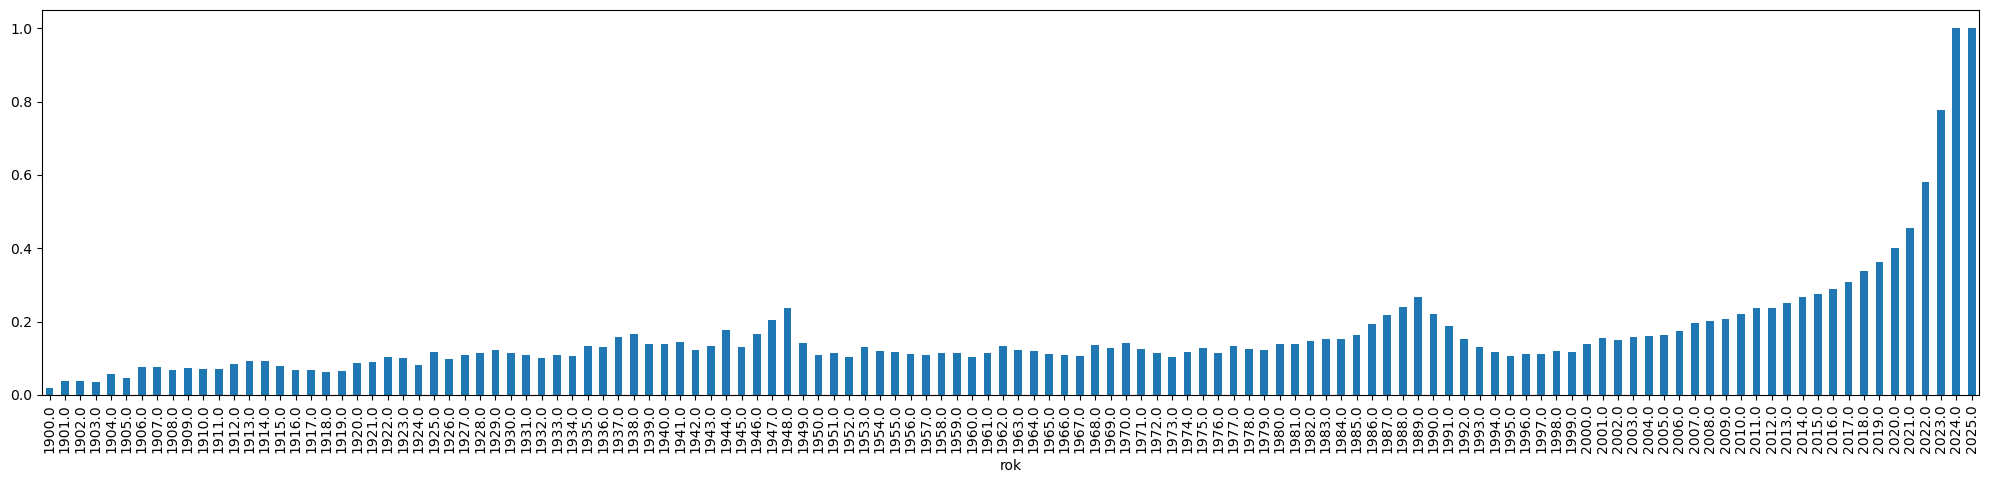

In [145]:
(naposled / kolikautorstva).plot.bar(figsize=(25,5))

### Kdo byl nejvydávanější, kdo už nevychází

In [147]:
poslednirok = df[df['100_7'].isin(opakovaneautorstvo)].groupby('100_7')['rok'].max()
prevrat = poslednirok[poslednirok == 1948].index.to_list()
revoluce = poslednirok[poslednirok == 1989].index.to_list()

In [148]:
df[df['100_7'].isin(prevrat)].groupby('100_a').size().nlargest(10)

100_a
Vyskočil, Quido Maria,              164
Pulec, František,                    74
Kudela, Josef,                       73
Drtina, František,                   72
Křenek, Josef,                       72
Zíka, Vláďa,                         70
Baldessari Plumlovská, Vojtěška,     67
Vojíř, Rudolf František,             65
Petrus, Jan,                         57
Urban, Jaroslav František,           56
dtype: int64

In [149]:
df[df['100_7'].isin(revoluce)].groupby('100_a').size().nlargest(10)

100_a
Nejedlý, Zdeněk,                 257
Pazourek, Vladimír,               82
Konrád, Karel,                    80
Èrenburg, Il‘ja Grigor‘jevič,     77
Hrabák, Josef,                    68
Krejčí, F. V.                     66
Šajner, Donát,                    65
Chytilová, Marta,                 64
Egermayer, František,             63
Pluhař, Zdeněk,                   55
dtype: int64

## Podíl odmlk (opět bez koumání, zda žil/nežil atd.)

In [151]:
import warnings

In [152]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [153]:
def odmlceni(frame, delka, zacatek, konec):
    statistiky = {}
    for i in range(zacatek, konec):
        if i % 10 == 0:
            print(i)
        tenrok = frame[(frame['rok'] == i)]['100_7'].drop_duplicates().to_list()
        try:
            statistiky[i] = 1 - (len(frame[(frame['100_7'].isin(tenrok)) & (frame['rok'] >= i + delka + 1)]['100_7'].drop_duplicates().to_list()) / len(tenrok))
        except:
            pass
    return pd.Series(statistiky)

In [154]:
celkovestatistiky5 = odmlceni(df[df['100_7'].isin(opakovaneautorstvo)], 5, 1900, 2019)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

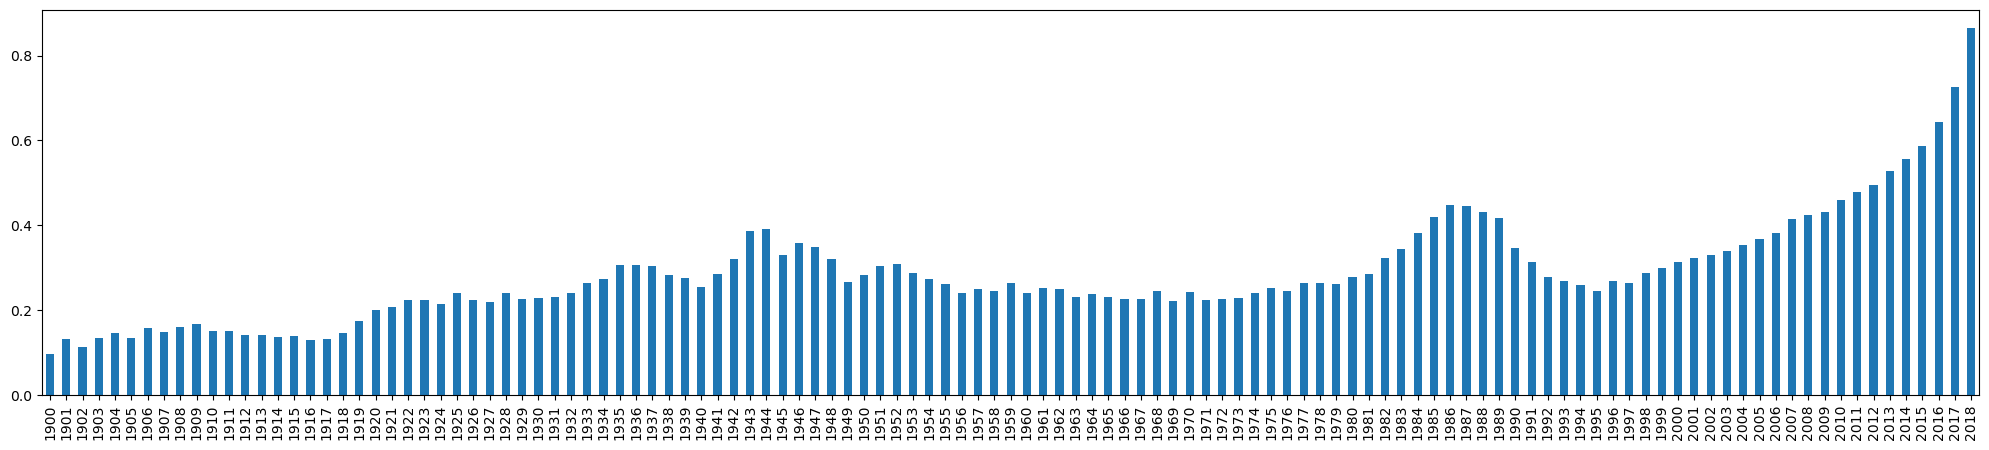

In [155]:
celkovestatistiky5.plot.bar(figsize=(25,5))

In [156]:
celkovestatistiky10 = odmlceni(df[df['100_7'].isin(opakovaneautorstvo)], 10, 1900, 2009)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


<Axes: >

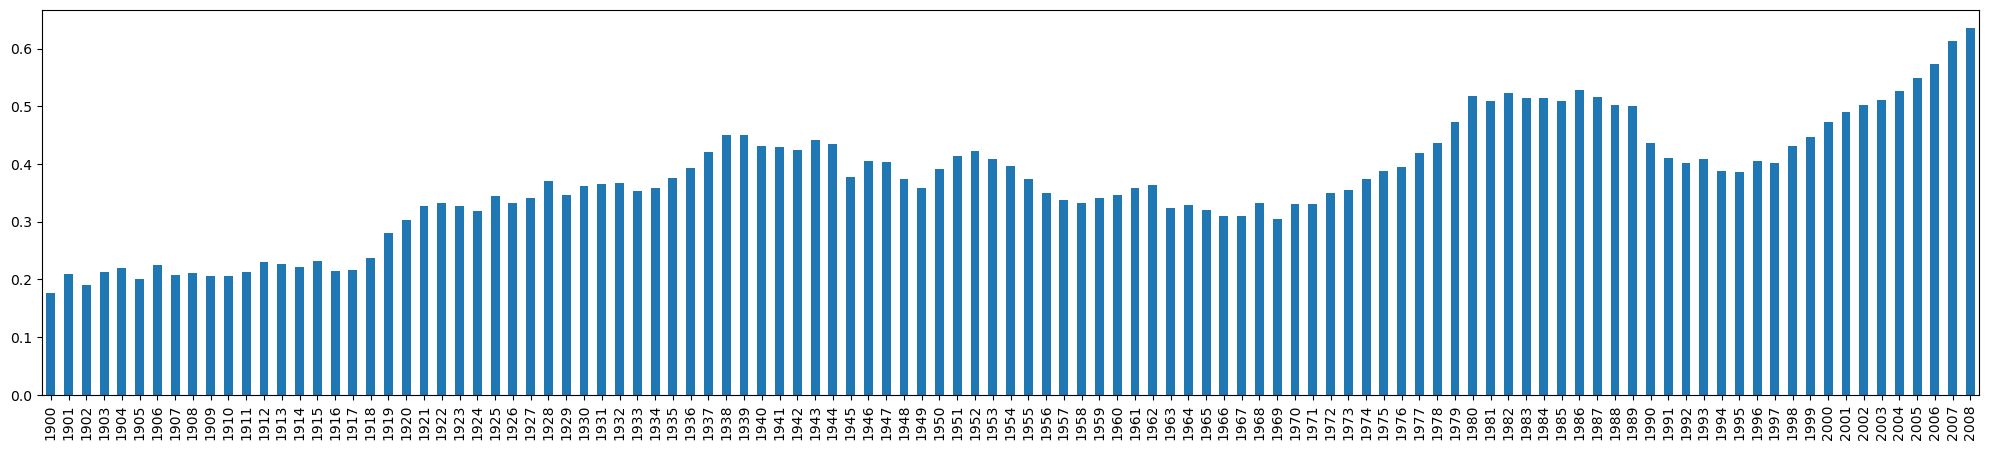

In [157]:
celkovestatistiky10.plot.bar(figsize=(25,5))

In [158]:
celkovestatistiky15 = odmlceni(df[df['100_7'].isin(opakovaneautorstvo)], 15, 1900, 2009)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


<Axes: >

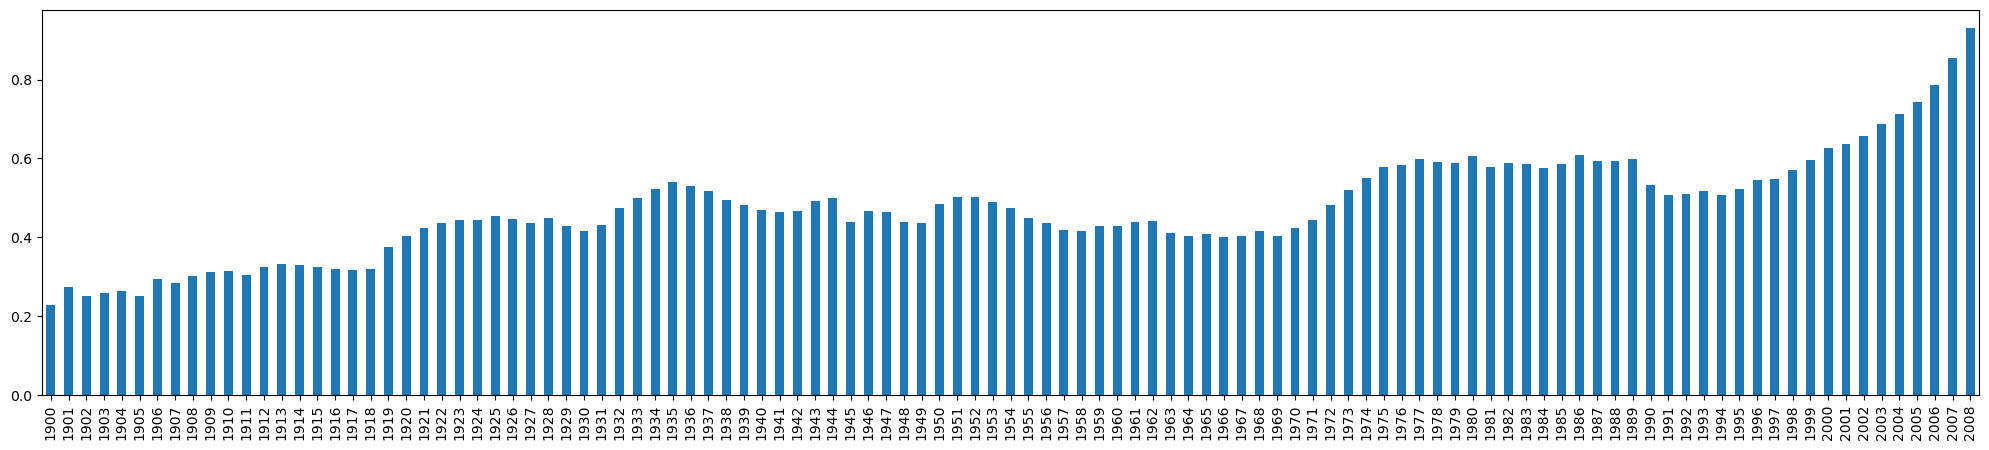

In [159]:
celkovestatistiky15.plot.bar(figsize=(25,5))

In [160]:
celkovestatistiky25 = odmlceni(df[df['100_7'].isin(opakovaneautorstvo)], 25, 1900, 2009)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


<Axes: >

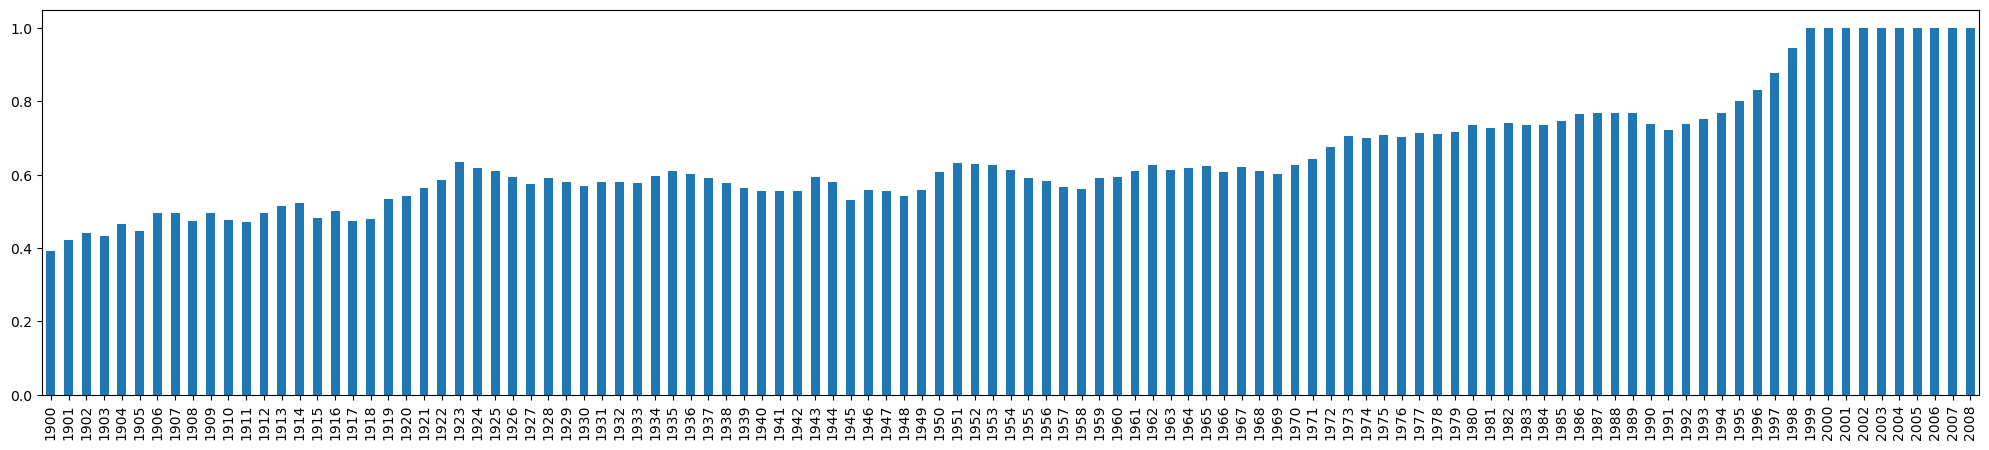

In [161]:
celkovestatistiky25.plot.bar(figsize=(25,5))

## III. Poměry odmlk českého autorstva

In [163]:
len(df)

633012

In [164]:
aut = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [165]:
aut = aut.explode('370_c')

In [166]:
aut.groupby('370_c').size().nlargest(20)

370_c
Česko                     360947
Spojené státy americké     65723
Německo                    54322
Velká Británie             32205
Francie                    20672
Polsko                     19632
Rusko                      17717
Slovensko                  16118
Itálie                     13560
Rakousko                   10402
Španělsko                   6983
Kanada                      6952
Švýcarsko                   6313
Nizozemsko                  5496
Ukrajina                    5122
Austrálie                   4652
Belgie                      3763
Maďarsko                    3700
Švédsko                     3500
Srbsko                      3136
dtype: int64

In [167]:
# aut = aut[aut['370_c'] == 'Česko']

In [168]:
aut = aut.reset_index(drop=False).explode('100_7')

In [169]:
aut[['100_7']]

,100_7
0,jk01010001
1,jk01010002
2,jk01010003
3,jk01010004
4,jk01010005
...,...
1262221,xx0323367
1262222,xx0323368
1262223,xx0323369
1262224,xx0323370


In [170]:
len(df)

633012

In [171]:
len(aut)

1262226

In [172]:
df2 = pd.merge(df, aut[['100_7','370_c']].drop_duplicates(subset=['100_7']), left_on='100_7', right_on='100_7', how='left')

In [173]:
df2 = df2[df2['370_c'] == 'Česko']

In [174]:
len(df2)

453525

<Axes: xlabel='rok'>

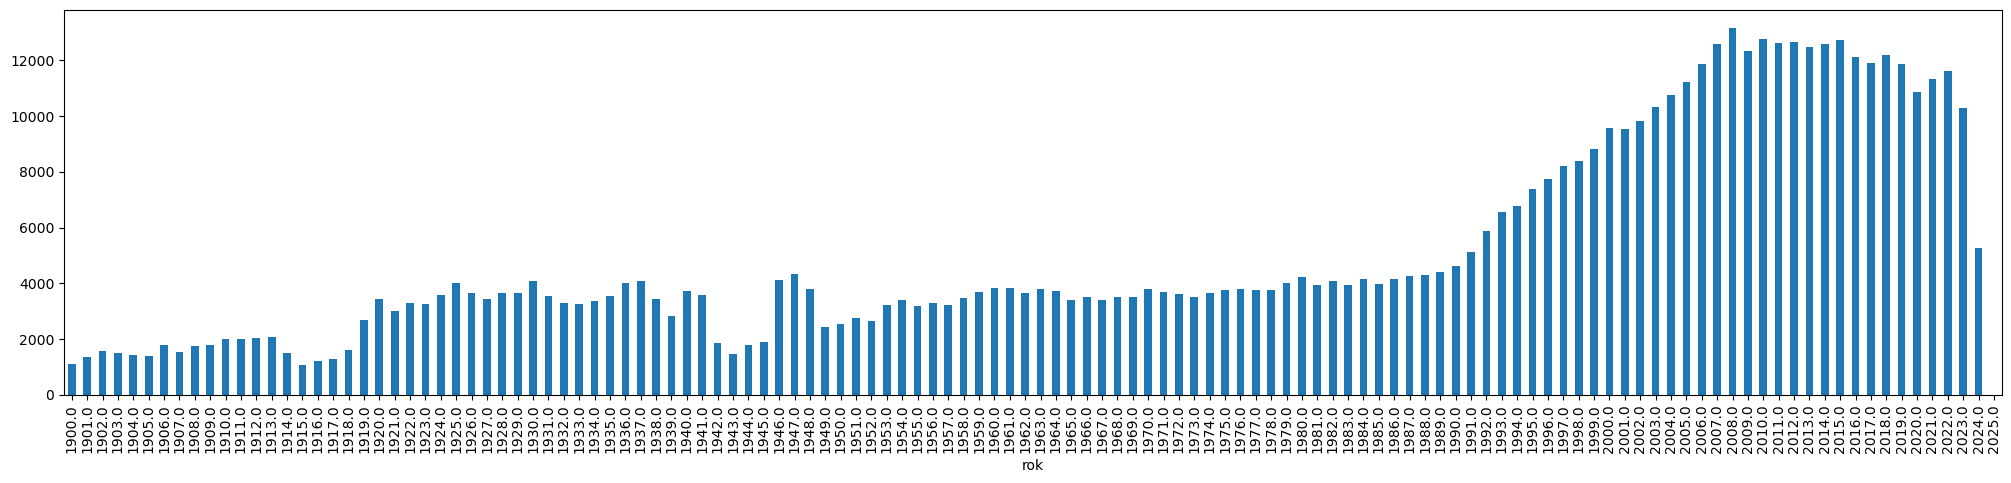

In [175]:
df.groupby('rok').size().plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

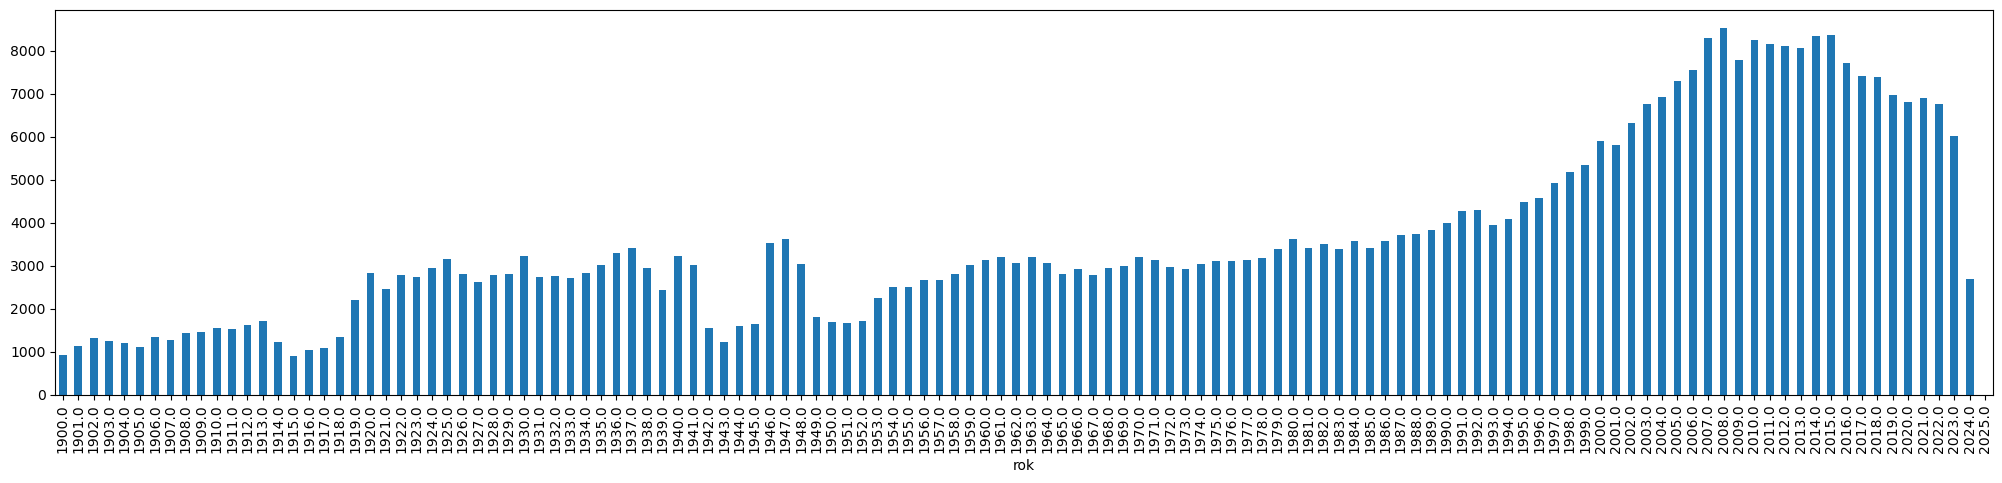

In [176]:
df2.groupby('rok').size().plot.bar(figsize=(25,5))

In [177]:
df2[df2['100_a'].str.contains('Kašpárek, Michal',na=False)]

,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,520_a,520_b,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,rok,370_c
498247,180516s2018 xr g 000 j cze,[978-80-7549-850-2],None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-323.1)]",[aut],jx20100301005,"Kašpárek, Michal,",1984-,None,Hry bez hranic /,Michal Kašpárek,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Praha :],"[Euromedia,]",[2018],[1],[156 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,None,None,"[české novely, satirické novely, Czech novella...",None,None,None,None,None,None,None,None,None,[Euromedia Group - Listen],None,nam a22 i 4500,2018.0,Česko
562820,230925s2023 xr g 000 f cze,[978-80-7637-400-3],None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jx20100301005,"Kašpárek, Michal,",1984-,None,Fosilie /,Michal Kašpárek,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2023],[1],[183 stran ;],None,[20 cm],None,None,None,"[Tři generace, tři životní názory a postoje. D...","[Děda, bývalý učitel tělocviku, vnímá, že svět...",None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,2023.0,Česko


In [178]:
cesi10 = odmlceni(df2[df2['100_7'].isin(opakovaneautorstvo)], 10, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

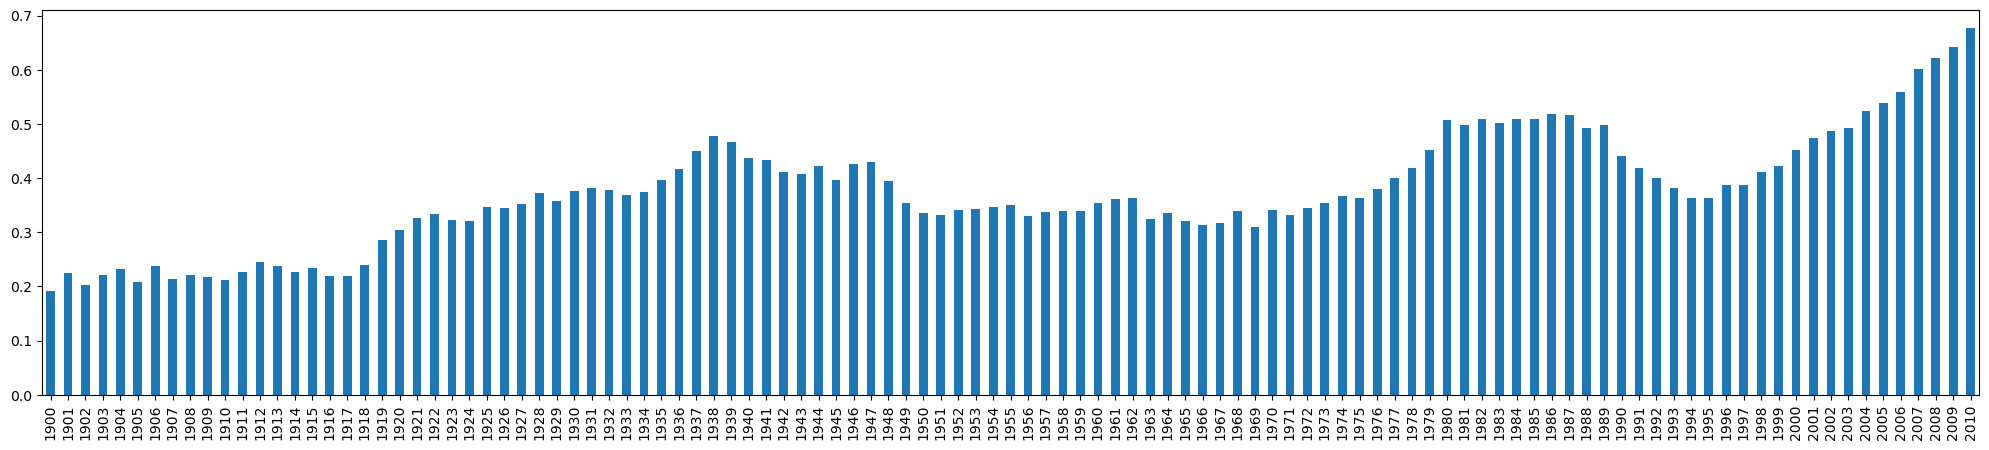

In [179]:
cesi10.plot.bar(figsize=(25,5))

In [180]:
cesi20 = odmlceni(df2[df2['100_7'].isin(opakovaneautorstvo)], 20, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

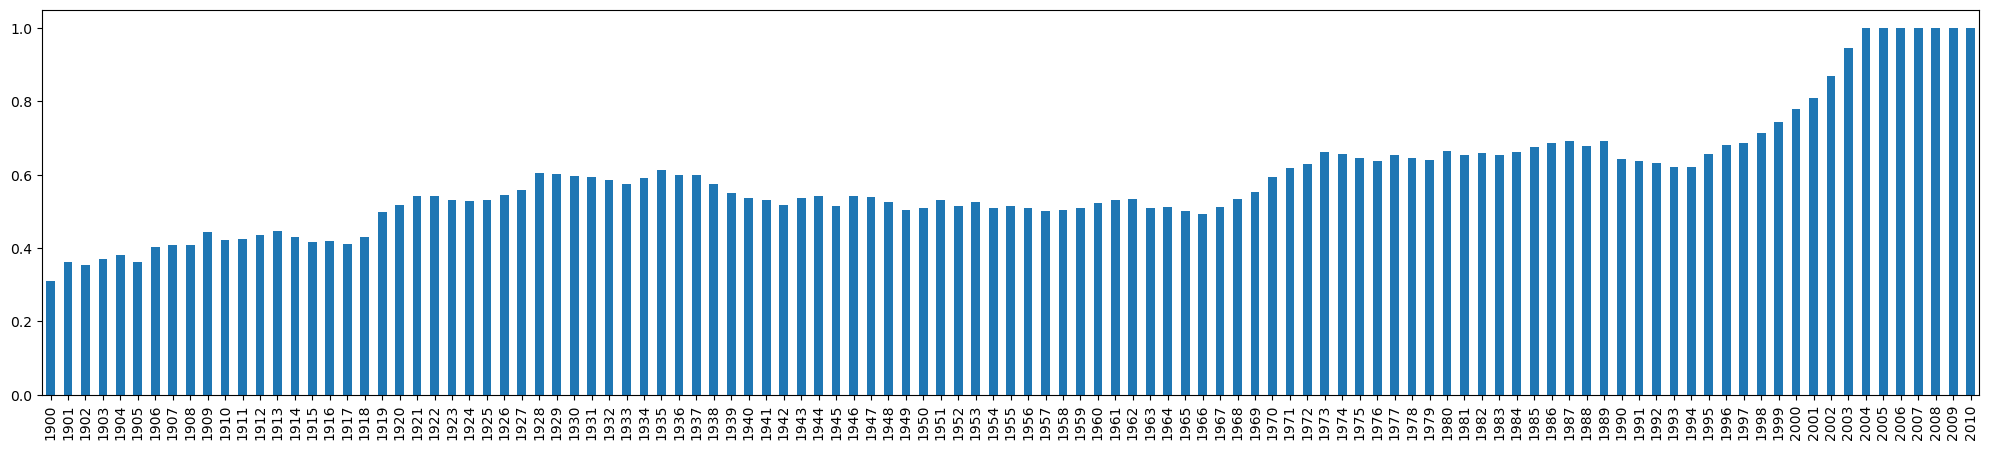

In [181]:
cesi20.plot.bar(figsize=(25,5))

In [182]:
cesi3 = odmlceni(df2[df2['100_7'].isin(opakovaneautorstvo)], 3, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

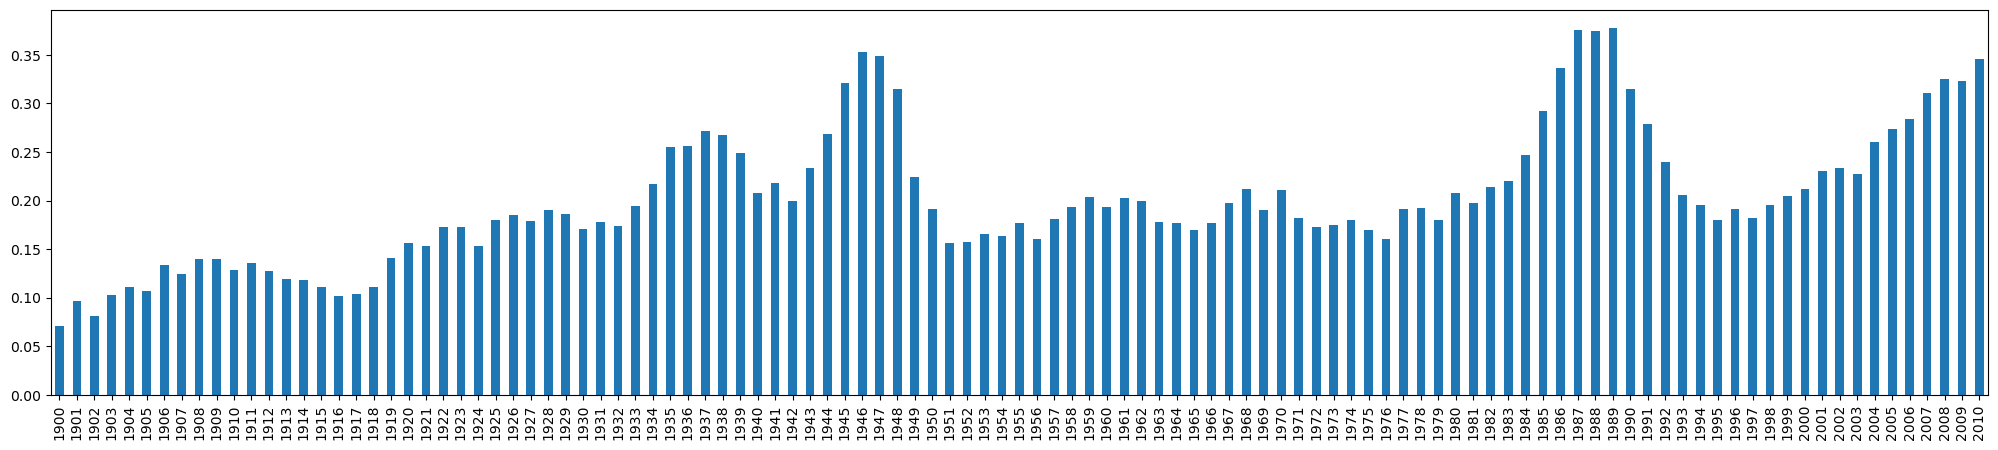

In [183]:
cesi3.plot.bar(figsize=(25,5))

## IV. test cizinstvem

In [185]:
df3 = pd.merge(df, aut[['100_7','370_c']].drop_duplicates(subset=['100_7']), left_on='100_7', right_on='100_7', how='left')
df3 = df3[df3['370_c'] == 'Spojené státy americké']

In [186]:
cizinstvo = odmlceni(df3, 15, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

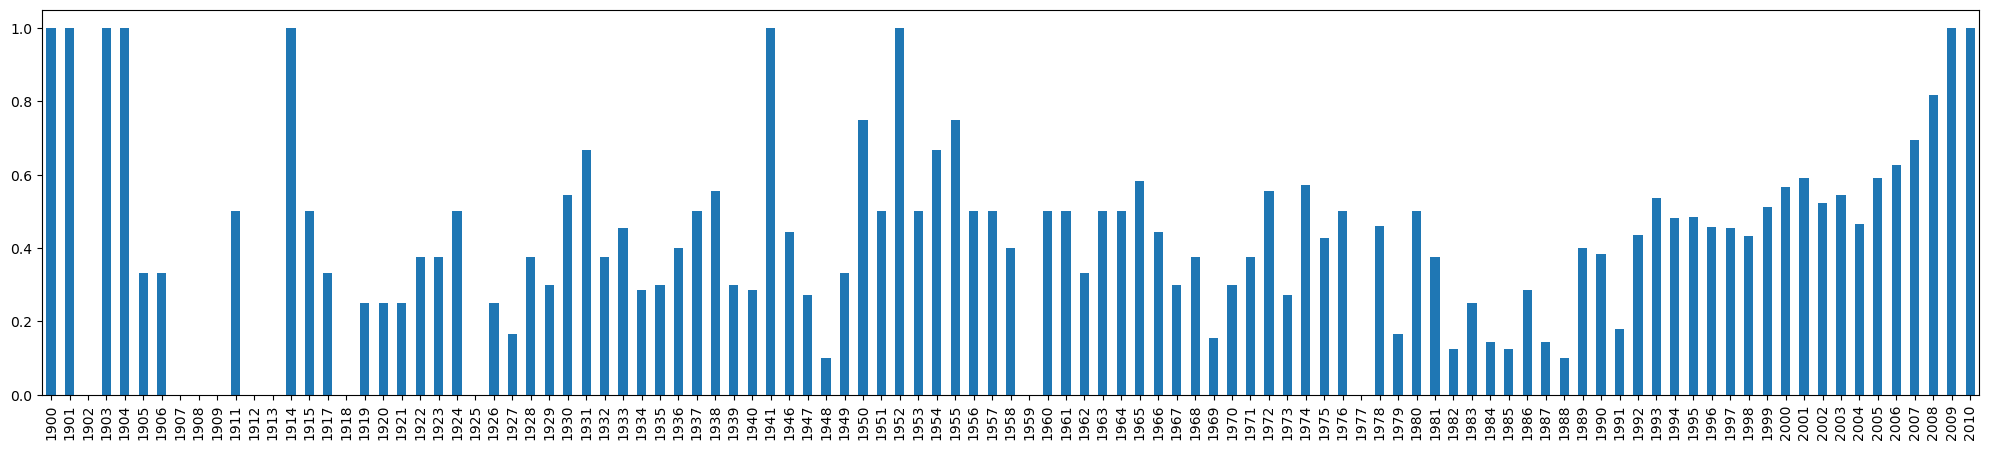

In [187]:
cizinstvo.plot.bar(figsize=(25,5))

## V. pouze žijící

In [189]:
wikid = pd.read_parquet(os.path.join('data','wikidata.parquet'))

In [190]:
wikid.columns

Index(['024_a', 'ceny', 'druh_umrti', 'facebook', 'instagram',
       'jazykove_verze', 'label_cs', 'label_en', 'manzelstvo', 'obcanstvi',
       'partnerstvo', 'popis_cs', 'popis_en', 'potomstvo', 'pricina_umrti',
       'profese', 'role', 'skoly', 'sourozenectvo', 'strany', 'twitter',
       'udalosti', 'vezeni', 'w_gender', 'w_misto_narozeni', 'w_misto_umrti',
       'w_narozeni', 'w_narozeni_presne', 'w_umrti', 'w_umrti_presne', 'web',
       'wiki_cs', 'wiki_en'],
      dtype='object')

In [191]:
wikid = wikid[['label_cs','w_umrti','w_narozeni','obcanstvi','ceny']]

In [192]:
ceny = wikid.explode('ceny')
topceny = ceny.groupby('ceny').size().nlargest(50)
topceny

ceny
Guggenheimovo stipendium                                             1236
Řád rudého praporu práce                                             1046
Leninův řád                                                           923
rytíř Řádu čestné legie                                               692
Řád čestného odznaku                                                  627
důstojník Řádu čestné legie                                           430
Stalinova cena                                                        406
člen Královské společnosti                                            395
společník Americké akademie umění a věd                               394
medaile Za udatnou práci za velké vlastenecké války 1941–1945         390
Řád rudé hvězdy                                                       383
rytíř Řádu znovuzrozeného Polska                                      353
medaile Za vítězství nad Německem                                     320
medaile Za zásluhy               

In [193]:
antikomuniste = ceny[ceny['ceny'] == 'účastník odboje a odporu proti komunismu'].index.drop_duplicates().to_list()
rudi = ceny[ceny['ceny'] == 'Řád rudého praporu práce'].index.drop_duplicates().to_list()

In [194]:
len(antikomuniste)

229

In [195]:
wikid

,label_cs,w_umrti,w_narozeni,obcanstvi,ceny
jk01010005,Karel Absolon,1960.0,1877.0,"[Československo, Předlitavsko]",None
jk01010022,Karel Adam,1971.0,1890.0,[Československo],None
jk01010023,Milan Adam,2008.0,1928.0,[Československo],"[čestný doktor, honorary doctorate of the Univ..."
jk01010026,Stanislav Adam,1974.0,1889.0,[Československo],None
jk01010030,Daniel Adam z Veleslavína,1599.0,1546.0,[Čechy],None
...,...,...,...,...,...
zmp2016925673,Kathy Kacer,NaN,1954.0,[Spojené státy americké],None
zmp2016925675,Angelus Kafka,1870.0,1791.0,None,None
zmp20191037071,Deborah Feldman,NaN,1986.0,"[Spojené státy americké, Německo]",None
zmp20191054500,Bernhard Heilig,1943.0,1902.0,[Německá říše],None


In [196]:
df3 = df.merge(wikid, left_on='100_7', right_index=True, how='left')

In [197]:
def narozeni(radek):
    if radek['100_d'] != None:
        if '-' in radek['100_d']:
            if len(radek['100_d'].split('-')[0]) == 4:
                return pd.to_numeric(radek['100_d'].split('-')[0])
    elif radek['w_narozeni'] != None:
        return pd.to_numeric(radek['w_narozeni'])

In [198]:
def umrti(radek):
    if radek['100_d'] != None:
        if '-' in radek['100_d']:
            if len(radek['100_d'].split('-')[1]) == 4:
                return pd.to_numeric(radek['100_d'].split('-')[1])
    elif radek['w_umrti'] != None:
        return pd.to_numeric(radek['w_umrti'])

In [199]:
df3['narozeni'] = df3.apply(lambda row: narozeni(row), axis=1)
df3['umrti'] = df3.apply(lambda row: umrti(row), axis=1)

In [200]:
df3 = df3[df3['rok'] < df3['umrti']].sort_values(by='rok')

In [201]:
df3 = df3.drop_duplicates(subset=['100_a','245_a'],keep='first')

In [202]:
len(df3)

167945

In [203]:
vsichnicesi = aut[aut['370_c'] == 'Česko']['100_7'].drop_duplicates().to_list()

In [204]:
df3 = df3[df3['100_7'].isin(vsichnicesi)]

In [205]:
len(df3)

138199

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

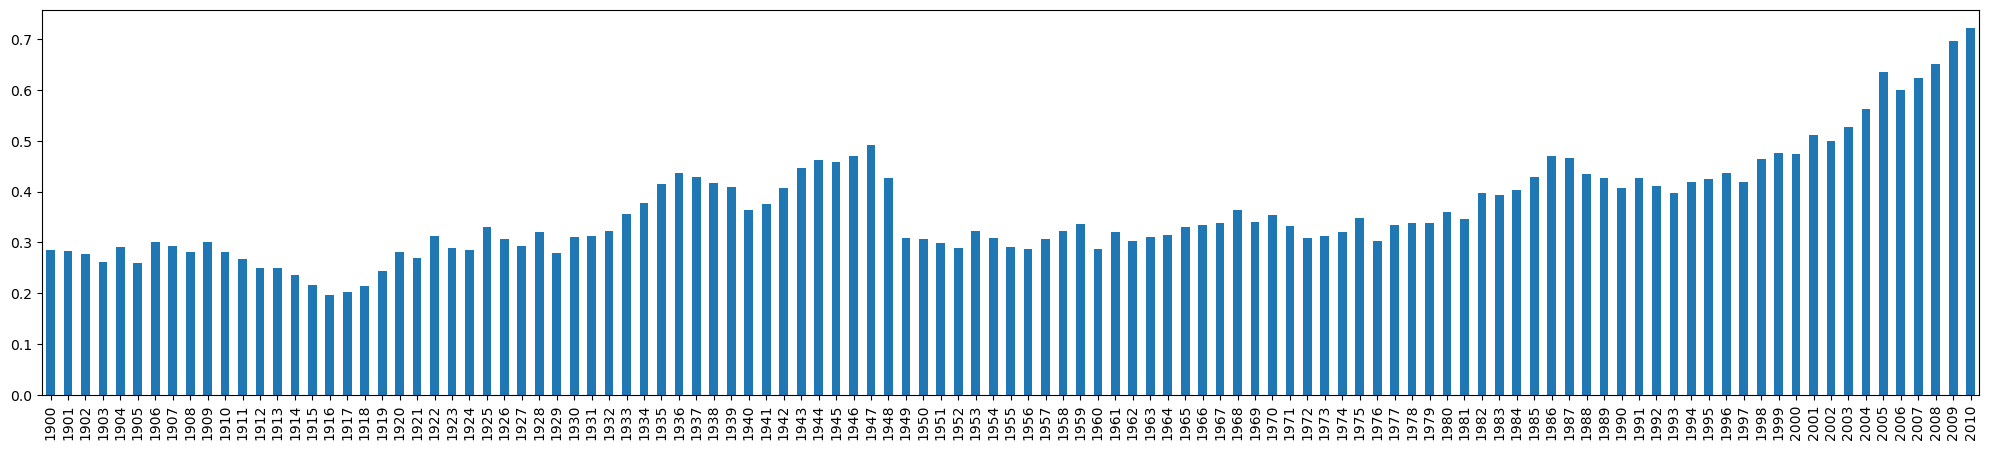

In [206]:
zijicicesi5 = odmlceni(df3, 5, 1900, 2011)
zijicicesi5.plot.bar(figsize=(25,5))

In [207]:
zijicicesi10 = odmlceni(df3, 10, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

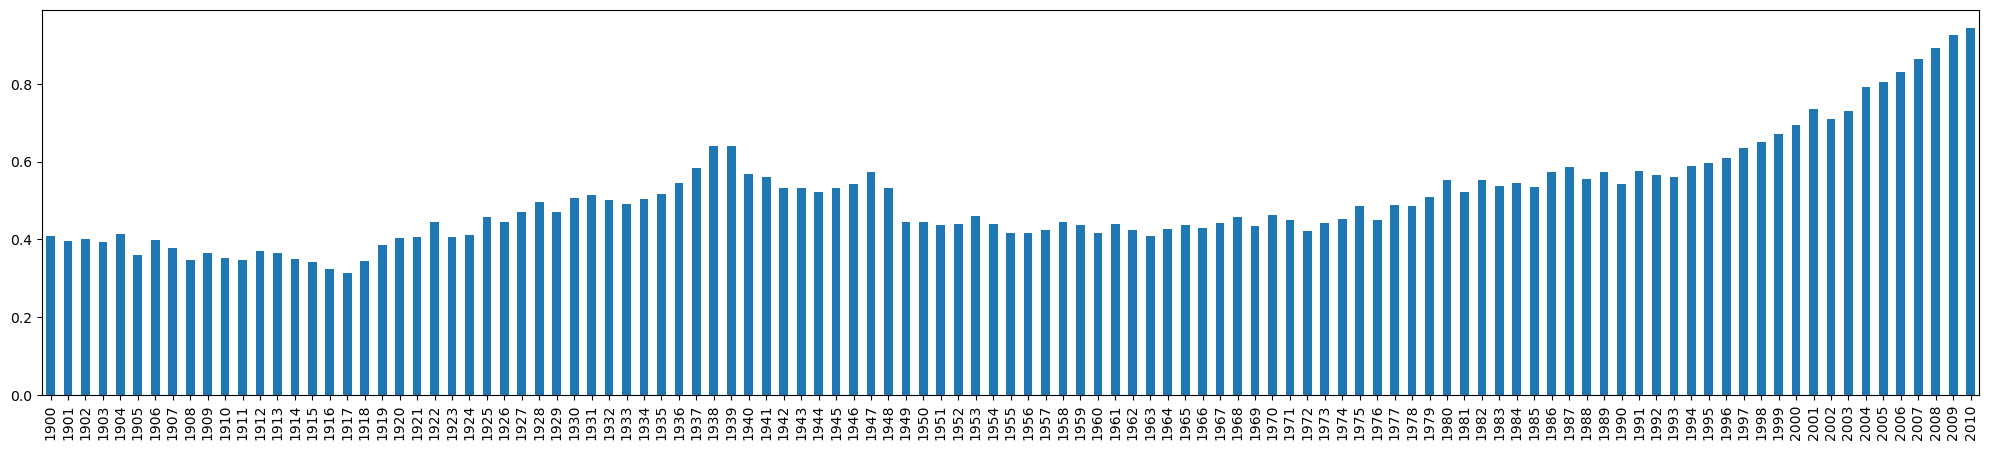

In [208]:
zijicicesi10.plot.bar(figsize=(25,5))

In [209]:
zijicicesi15 = odmlceni(df3, 15, 1900, 2011)

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

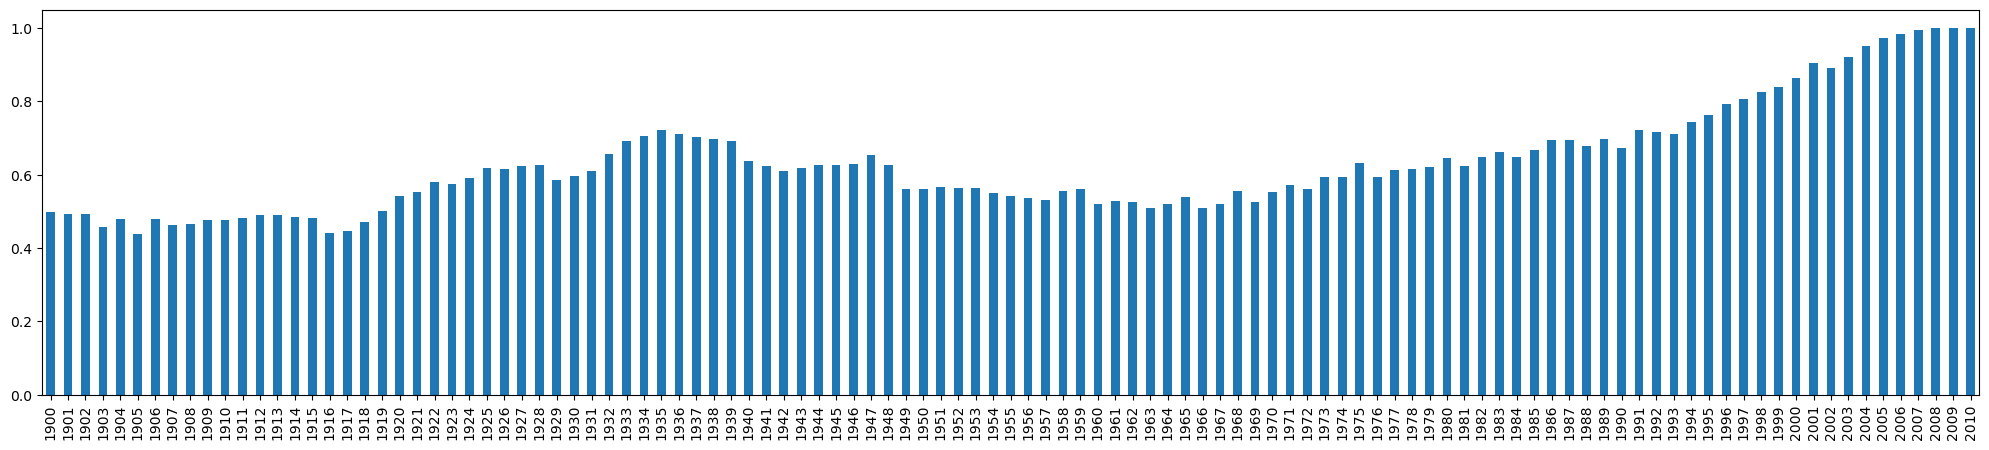

In [210]:
zijicicesi15.plot.bar(figsize=(25,5))

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

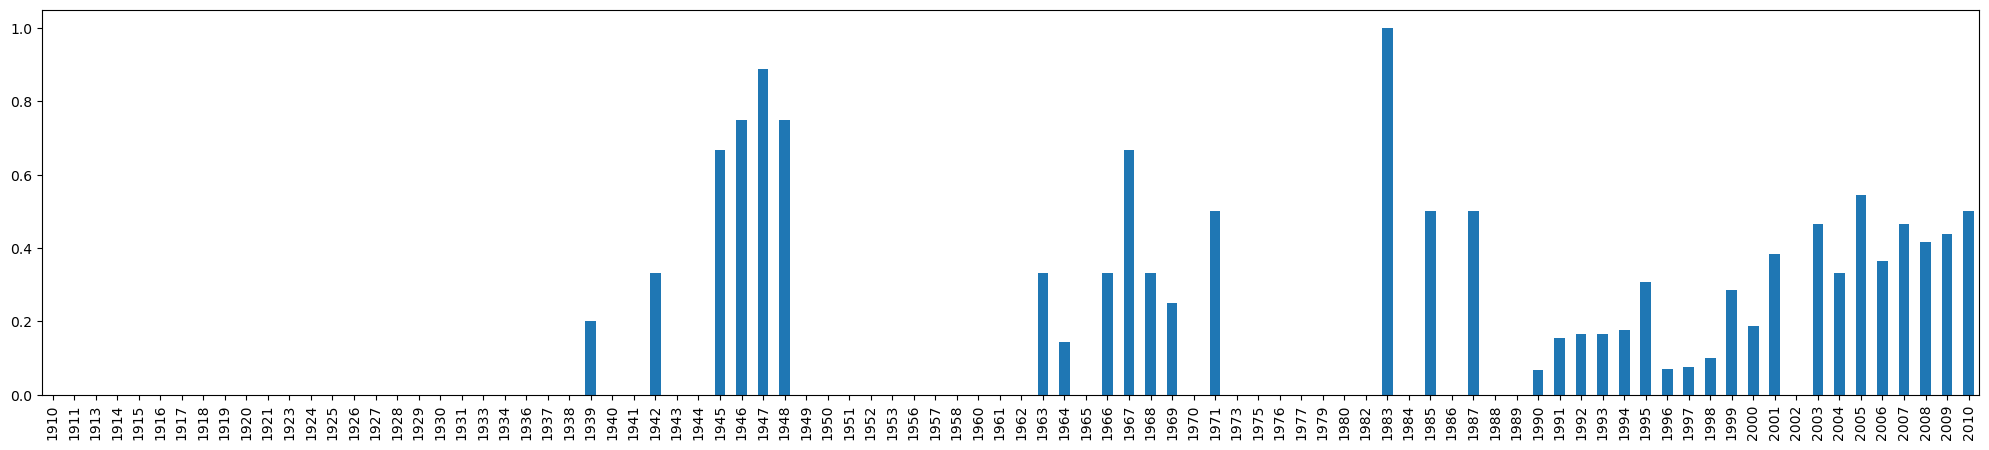

In [211]:
antikomuniste5 = odmlceni(df3[df3['100_7'].isin(antikomuniste)], 5, 1900, 2011)
antikomuniste5.plot.bar(figsize=(25,5))

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


<Axes: >

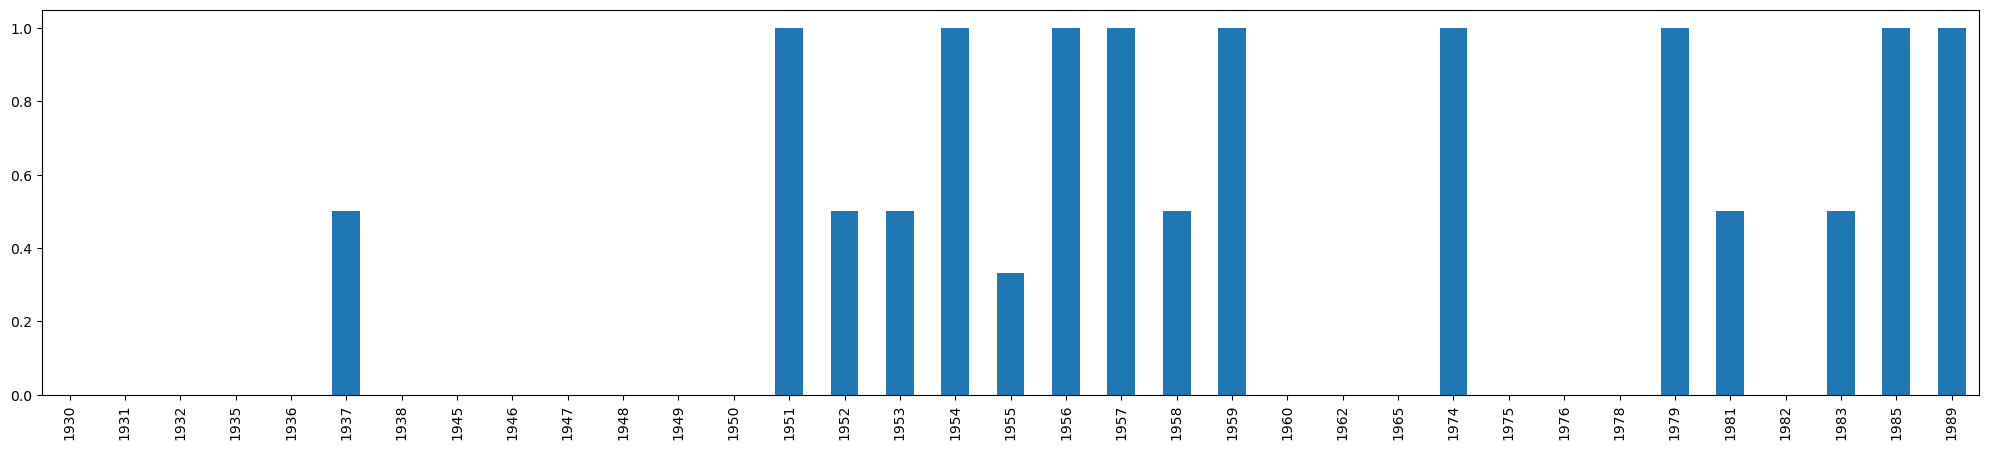

In [212]:
rudi5 = odmlceni(df3[df3['100_7'].isin(rudi)], 5, 1900, 2011)
rudi5.plot.bar(figsize=(25,5))

## VI. beletrie

In [299]:
dfb = pd.read_parquet(os.path.join('data','cnb_ceska_proza.parquet'))

In [301]:
len(dfb)

47195

In [303]:
dfb = dfb.merge(df[['100_7']], left_index=True, right_index=True, how="left")

In [305]:
len(dfb)

47195

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


<Axes: >

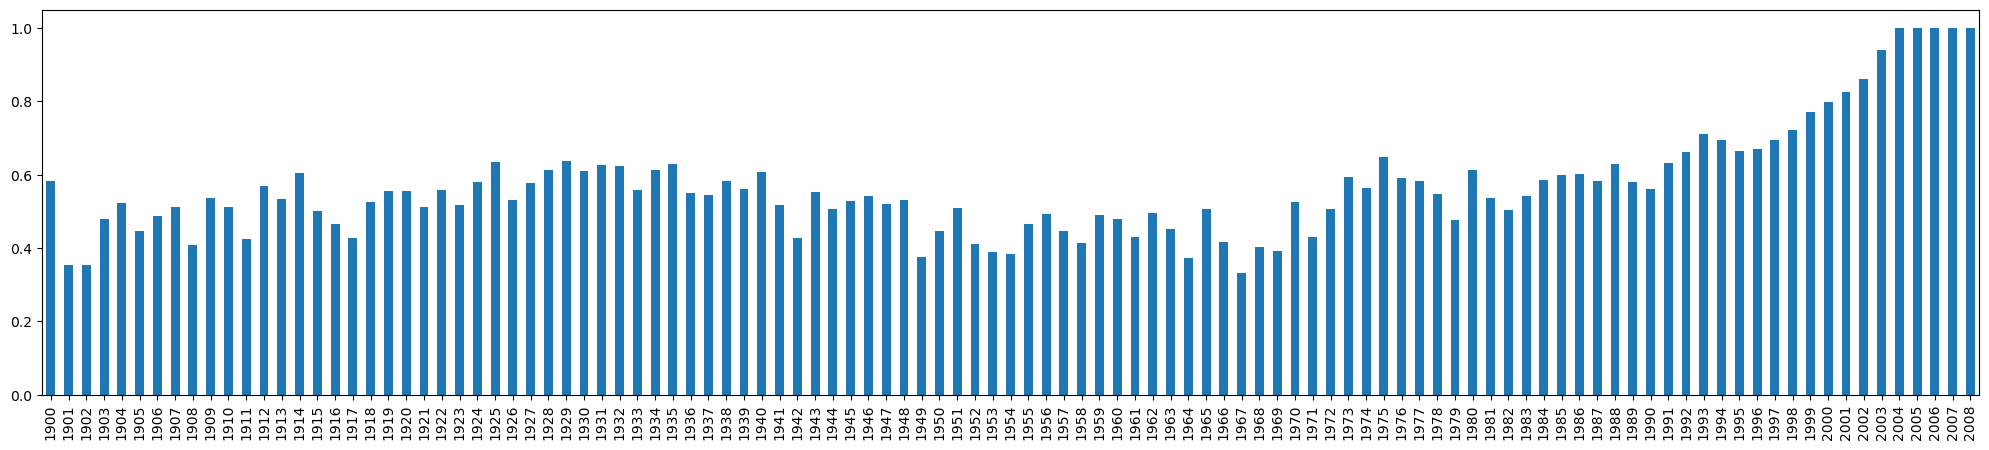

In [307]:
odmlceni(dfb, 20, 1900, 2009).plot.bar(figsize=(25,5))

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000


<Axes: >

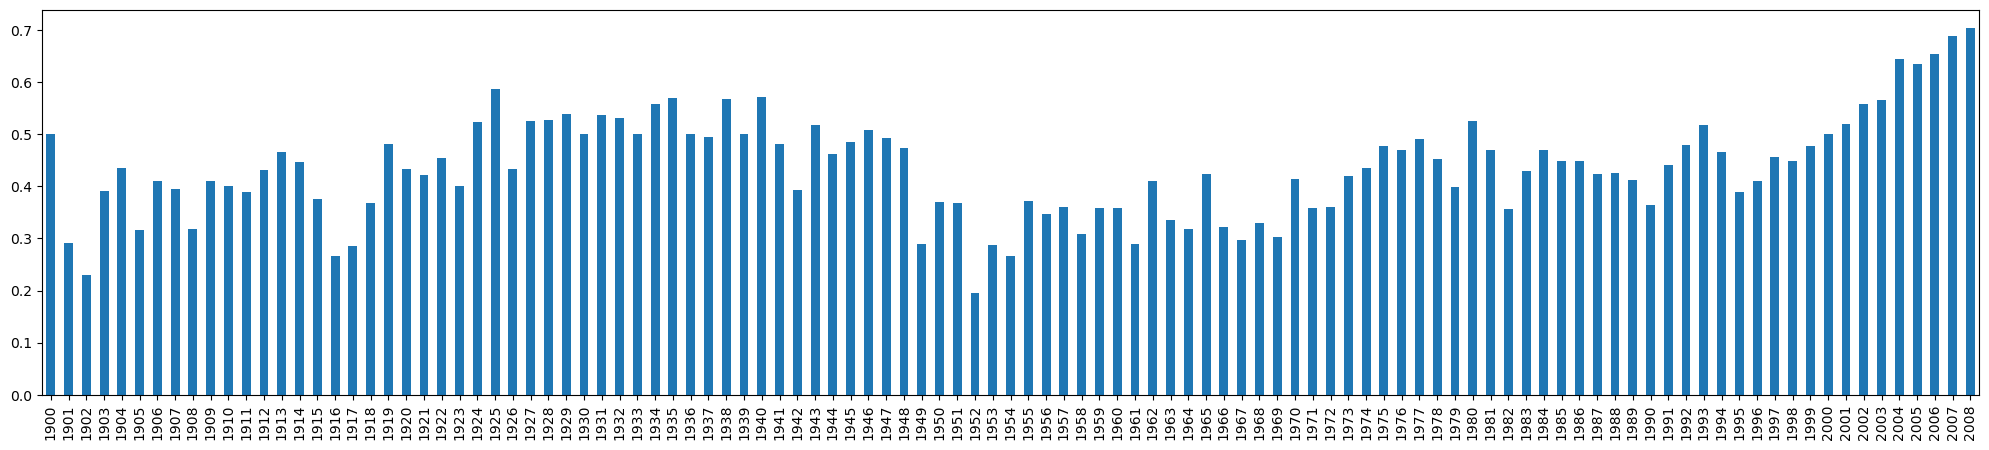

In [309]:
odmlceni(dfb, 10, 1900, 2009).plot.bar(figsize=(25,5))